In [2]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# helper functions

def add_shift(series):
    scale_factor = 0.2
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + rand_num for x in series[key]]
    return series

def add_noise(series):
    scale_factor = 0.05
    for key in series:
        if (key[-1] != 'z' and key[-1] != 'v'):
            rand_num = np.random.rand() * scale_factor - (scale_factor / 2)
            series[key] = [x + (np.random.rand() * scale_factor - (scale_factor / 2)) for x in series[key]]
    return series

def rand_augment(series):
    series = add_shift(series)
    series = add_noise(series)
    return series




def arr_rand_augment(series):
    raise NotImplementedError


def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]


def make_2D(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        key_list = []
        for e in series[key]:
            key_list.append([e]) # try brackets here
        l.append(key_list)
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (7.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (5.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (3.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= (1.0/18.0)):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def eval(pred, truth):
    o_pred = []
    o_truth = []
    f_pred = []
    f_truth = []
    b_pred = []
    b_truth = []
    s_pred = []
    s_truth = []
    l_pred = []
    l_truth = []
    for p in pred:
        o_pred.append(p[0])
        f_pred.append(p[1])
        b_pred.append(p[2])
        s_pred.append(p[3])
        l_pred.append(p[4])
    for t in truth:
        o_truth.append(t[0])
        f_truth.append(t[1])
        b_truth.append(t[2])
        s_truth.append(t[3])
        l_truth.append(t[4])
    return [[E0(o_pred, o_truth), E1(o_pred, o_truth), E2(o_pred, o_truth), E3(o_pred, o_truth)],
            [E0(f_pred, f_truth), E1(f_pred, f_truth), E2(f_pred, f_truth), E3(f_pred, f_truth)],
            [E0(b_pred, b_truth), E1(b_pred, b_truth), E2(b_pred, b_truth), E3(b_pred, b_truth)],
            [E0(s_pred, s_truth), E1(s_pred, s_truth), E2(s_pred, s_truth), E3(s_pred, s_truth)],
            [E0(l_pred, l_truth), E1(l_pred, l_truth), E2(l_pred, l_truth), E3(l_pred, l_truth)]]

In [50]:
''' https://github.com/HobbitLong/SupContrast/blob/master/losses.py '''

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask*log_prob).sum(1)/(mask.sum(1))

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [43]:
# setting up CNN

conv_1 = 32
conv_2 = 64
conv_3 = 128
conv_4 = 256

fc_size1 = 256
fc_size2 = 512
fc_size3 = 256
fc_size4 = 128
fc_size5 = 64
output_size = 2
batch_size = 371
learning_rate = 0.01
tmp = 0.07

bsz = 464
    

class SiameseNet(nn.Module):

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.1)

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.apply(self._init_weights)
        # conv layers
        self.conv1 = nn.Conv2d(conv_1, conv_2, (1,3), stride=1)
        self.conv2 = nn.Conv2d(conv_2, conv_3, (1,3), stride=1)
        self.conv3 = nn.Conv2d(conv_3, conv_4, (1,3), stride=1)
        # fc layers
        self.fc1 = nn.Linear(fc_size1, fc_size2)
        self.fc2 = nn.Linear(fc_size2, fc_size3)
        self.fc3 = nn.Linear(fc_size3, fc_size4)
        self.fc4 = nn.Linear(fc_size4, fc_size5)
        self.fc5 = nn.Linear(fc_size5, output_size)
        # sigmoid
    
    def forward(self, x):
        # convolutions
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.1)

        #print('AFTER CONV: ' + str(x.size()))

        x = torch.flatten(x, 0)

        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.1)

        x = F.normalize(x, p=2, dim=0)

        return x

model = SiameseNet()

loss_function = SupConLoss(temperature=tmp)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
# loading data into 2 views

dir = '..\\time_series\\Time_normalized_stages\\4_final\\'

n_views = 2

orig_x = []
labels = []
X_train = []

for file in os.listdir(dir):
    series, num_frames = load_series(dir + file)
    labels.append(float(file[4]) / 9)
    orig_x.append(series)

for example in orig_x:
    x1 = make_2D(rand_augment(example))
    x2 = make_2D(rand_augment(example))
    X_train.append([x1, x2])

X_train = torch.tensor(X_train)

for example in X_train:
    print(example)

print(torch.tensor(X_train).size())

list_features = [[model(torch.tensor(ex).permute(0, 2, 1)) for ex in pair] for pair in X_train]
features = torch.Tensor(bsz, n_views, output_size)
#print(list_features)

for pair in list_features:
    print(pair)
    torch.cat(features, pair)
    break

torch.cat(list_features, out=features)

features = torch.cat(torch.unsqueeze(features, dim=0))
print(features.size())

labels = torch.tensor(labels)
print(labels.size())

print(loss_function(features, labels))


tensor([[[[ 1.4991e-02],
          [ 2.3602e-01],
          [ 2.4772e-01],
          [ 8.6406e-02],
          [ 5.8682e-02],
          [-2.5225e-02],
          [ 3.5814e-02]],

         [[ 1.4795e+00],
          [ 1.4270e+00],
          [ 1.4208e+00],
          [ 1.4041e+00],
          [ 1.4243e+00],
          [ 1.4968e+00],
          [ 1.4429e+00]],

         [[ 1.2577e-01],
          [ 6.4242e-02],
          [-3.1650e-02],
          [-2.8509e-02],
          [ 5.4330e-02],
          [-1.0362e-01],
          [-2.0483e-01]],

         [[ 1.3925e+00],
          [ 1.3269e+00],
          [ 1.2570e+00],
          [ 1.2536e+00],
          [ 1.2843e+00],
          [ 1.3240e+00],
          [ 1.3454e+00]],

         [[-2.0419e-01],
          [ 1.3335e-01],
          [ 2.3505e-01],
          [-8.1466e-02],
          [-2.3153e-01],
          [-3.1784e-01],
          [-1.8988e-02]],

         [[ 9.5172e-01],
          [ 9.2667e-01],
          [ 9.4062e-01],
          [ 9.5123e-01],
          [ 1.0

C:\Users\adars\AppData\Local\Temp\ipykernel_22208\1182290127.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(X_train).size())
C:\Users\adars\AppData\Local\Temp\ipykernel_22208\1182290127.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_features = [[model(torch.tensor(ex).permute(0, 2, 1)) for ex in pair] for pair in X_train]


[tensor([ 0.8415, -0.5402], grad_fn=<DivBackward0>), tensor([ 0.8408, -0.5413], grad_fn=<DivBackward0>)]


TypeError: cat() received an invalid combination of arguments - got (Tensor, list), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


0


TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


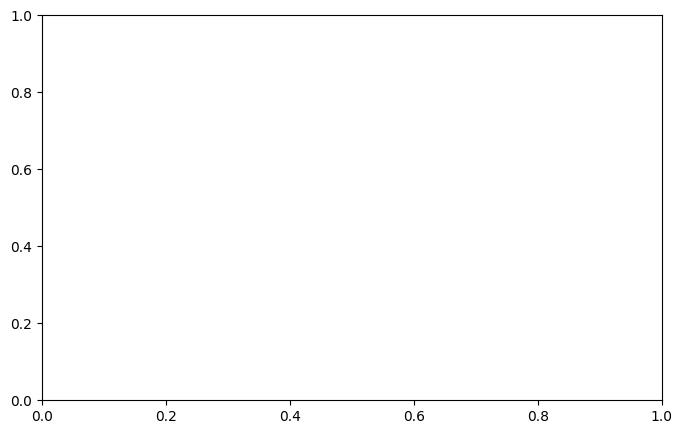

In [68]:
num_epochs = 1000
losses = []
fig, ax = plt.subplots(1, figsize=(8,5))

for epoch in range(num_epochs):
    model.train()
    print(epoch)
    result = model(orig_x)
    features = torch.tensor([[x] for x in results.tolist()])
    loss = loss_function(features, labels)
    print(loss)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

ax.plot(losses)


In [79]:
# trying loading the data into 1 view

X_train = []
orig_x = []
labels = []

dir = '..\\time_series\\Time_normalized_stages\\4_final\\'
n_views = 1
for file in os.listdir(dir):
    series, num_frames = load_series(dir + file)
    labels.append(float(file[4]) / 9)
    orig_x.append(series)

labels = torch.tensor(labels)

for example in orig_x:
    X_train.append([make_2D(example)])

X_train = torch.tensor(X_train)
print(X_train.size())
features2 = torch.Tensor(464, 1, 2)
for i in range(464):
    features2[i][0] = model(X_train[i].permute(0, 1, 3, 2))

print(loss_function(features2, labels))

print(features2.size())


torch.Size([464, 1, 32, 7, 1])
tensor(6.1377, grad_fn=<MeanBackward0>)
torch.Size([464, 1, 2])


Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


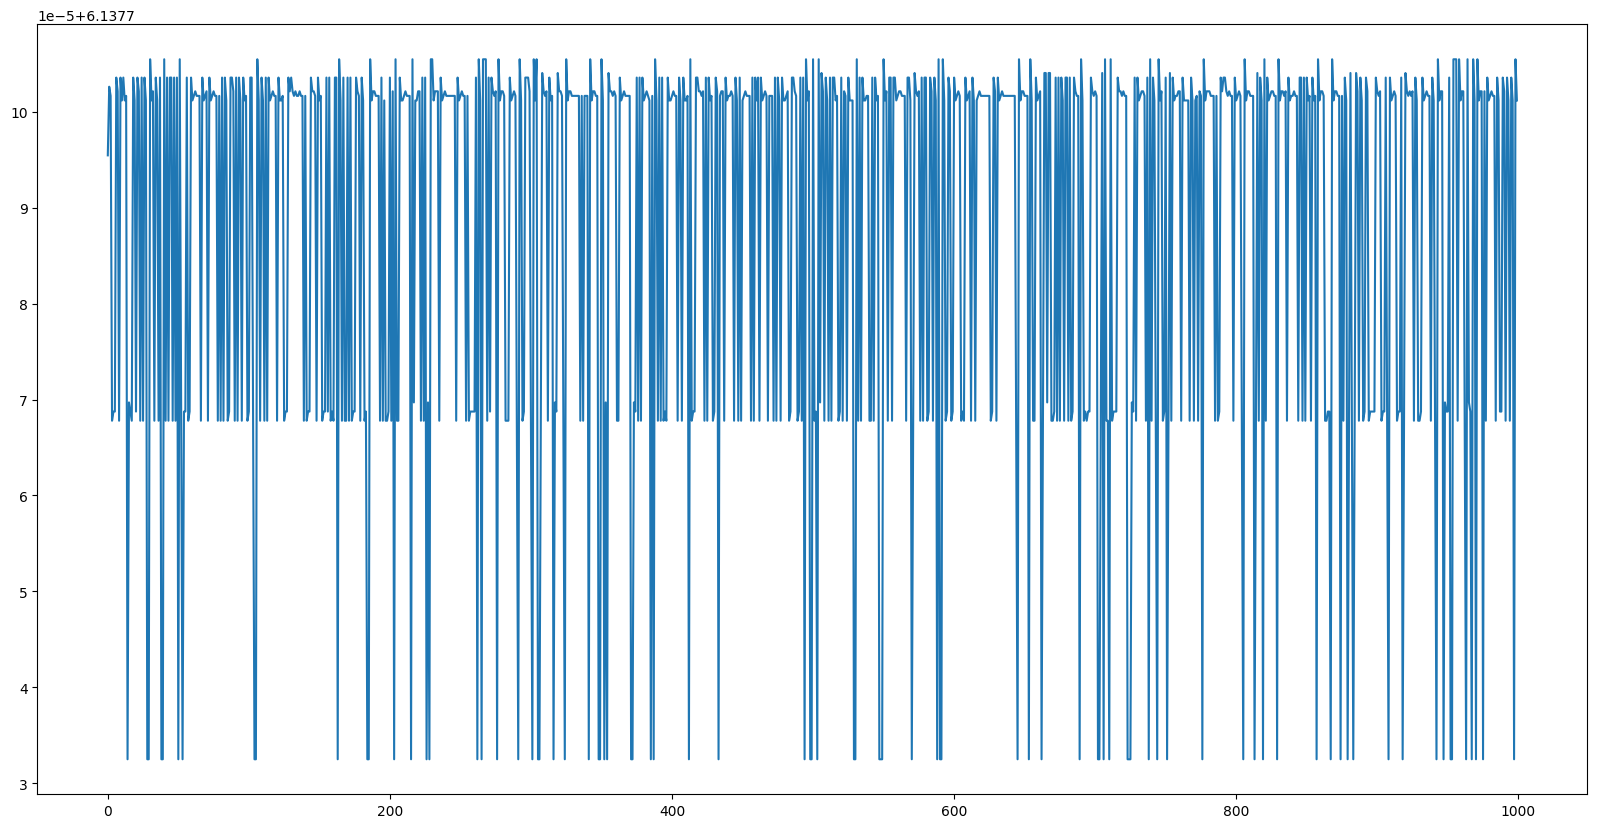

In [80]:
def get_features():
    features = torch.Tensor(464, 1, 2)
    for i in range(464):
        features[i][0] = model(X_train[i].permute(0, 1, 3, 2))
        return features

model.apply(model._init_weights)
losses = []
for epoch in range(num_epochs):
    features = get_features()
    loss = loss_function(features, labels)
    loss.backward()
    optimizer.zero_grad()
    losses.append(loss.item())

    if (epoch % 100 == 0):
        print('Epoch ' + str(epoch))

fig, ax = plt.subplots(1, figsize=(20,10))
plt.plot(losses)

In [81]:
# load data
with open("..\\test_examples.txt") as t:
    test_files = t.readlines()

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

dir = '..\\time_series\\Time_normalized_stages\\4_final\\'
files = os.listdir(dir)

test_examples = []
test_labels = []

for file in test_files:
    series, num_frames = load_series(dir + file[:-1])
    test_examples.append(make_2D(series))
    test_labels.append(int(file[4]))

l_0 = []
l_1 = []
l_2 = []
l_3 = []
l_4 = []
l_5 = []
l_6 = []
l_7 = []
l_8 = []

for file in training_examples:
    series, num_frames = load_series(dir + file[:-1])
    label = int(file[4])
    if (label == 0):
        l_0.append(make_2D(series))
    elif (label == 1):
        l_1.append(make_2D(series))
    elif (label == 2):
        l_2.append(make_2D(series))
    elif (label == 3):
        l_3.append(make_2D(series))
    elif (label == 4):
        l_4.append(make_2D(series))
    elif (label == 5):
        l_5.append(make_2D(series))
    elif (label == 6):
        l_6.append(make_2D(series))
    elif (label == 7):
        l_7.append(make_2D(series))
    elif (label == 8):
        l_8.append(make_2D(series))

l_0 = torch.tensor(l_0)
l_1 = torch.tensor(l_1)
l_2 = torch.tensor(l_2)
l_3 = torch.tensor(l_3)
l_4 = torch.tensor(l_4)
l_5 = torch.tensor(l_5)
l_6 = torch.tensor(l_6)
l_7 = torch.tensor(l_7)
l_8 = torch.tensor(l_8)
test_examples = torch.tensor(test_examples)

l_0 = l_0.permute(0, 1, 3, 2)
l_1 = l_1.permute(0, 1, 3, 2)
l_2 = l_2.permute(0, 1, 3, 2)
l_3 = l_3.permute(0, 1, 3, 2)
l_4 = l_4.permute(0, 1, 3, 2)
l_5 = l_5.permute(0, 1, 3, 2)
l_6 = l_6.permute(0, 1, 3, 2)
l_7 = l_7.permute(0, 1, 3, 2)
l_8 = l_8.permute(0, 1, 3, 2)
test_examples = test_examples.permute(0, 1, 3, 2)

print(l_0.size())
print(l_1.size())
print(l_2.size())
print(l_3.size())
print(l_4.size())
print(l_5.size())
print(l_6.size())
print(l_7.size())
print(l_8.size())
print(test_examples.size())

X_train = [l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7, l_8]
print(type(X_train[0]))

torch.Size([44, 32, 1, 7])
torch.Size([94, 32, 1, 7])
torch.Size([78, 32, 1, 7])
torch.Size([54, 32, 1, 7])
torch.Size([34, 32, 1, 7])
torch.Size([25, 32, 1, 7])
torch.Size([16, 32, 1, 7])
torch.Size([18, 32, 1, 7])
torch.Size([8, 32, 1, 7])
torch.Size([93, 32, 1, 7])
<class 'torch.Tensor'>


SiameseNet(
  (conv1): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(1, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(1, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)

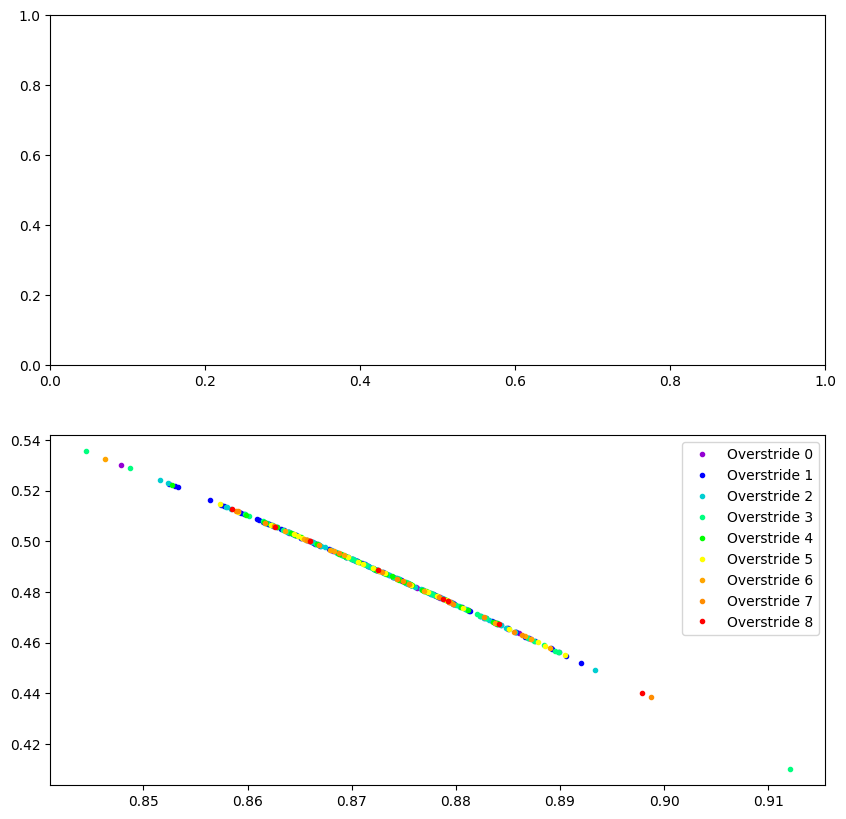

In [82]:
# examining 2d encodings


l0x = []
l0y = []
l1x = []
l1y = []
l2x = []
l2y = []
l3x = []
l3y = []
l4x = []
l4y = []
l5x = []
l5y = []
l6x = []
l6y = []
l7x = []
l7y = []
l8x = []
l8y = []

for example in X_train[0]:
    enc = model(example).tolist()
    l0x.append(enc[0])
    l0y.append(enc[1])

for example in X_train[1]:
    enc = model(example).tolist()
    l1x.append(enc[0])
    l1y.append(enc[1])

for example in X_train[2]:
    enc = model(example).tolist()
    l2x.append(enc[0])
    l2y.append(enc[1])

for example in X_train[3]:
    enc = model(example).tolist()
    l3x.append(enc[0])
    l3y.append(enc[1])

for example in X_train[4]:
    enc = model(example).tolist()
    l4x.append(enc[0])
    l4y.append(enc[1])

for example in X_train[5]:
    enc = model(example).tolist()
    l5x.append(enc[0])
    l5y.append(enc[1])

for example in X_train[6]:
    enc = model(example).tolist()
    l6x.append(enc[0])
    l6y.append(enc[1])

for example in X_train[7]:
    enc = model(example).tolist()
    l7x.append(enc[0])
    l7y.append(enc[1])

for example in X_train[8]:
    enc = model(example).tolist()
    l8x.append(enc[0])
    l8y.append(enc[1])

fig, ax = plt.subplots(2, figsize=(10, 10))

ax[1].plot(l0x, l0y, '.', c='darkviolet', label='Overstride 0')
ax[1].plot(l1x, l1y, '.', c='blue', label='Overstride 1')
ax[1].plot(l2x, l2y, '.', c='darkturquoise', label='Overstride 2')
ax[1].plot(l3x, l3y, '.', c='springgreen', label='Overstride 3')
ax[1].plot(l4x, l4y, '.', c='lime', label='Overstride 4')
ax[1].plot(l5x, l5y, '.', c='yellow', label='Overstride 5')
ax[1].plot(l6x, l6y, '.', c='orange', label='Overstride 6')
ax[1].plot(l7x, l7y, '.', c='darkorange', label='Overstride 7')
ax[1].plot(l8x, l8y, '.', c='red', label='Overstride 8')

ax[1].legend()

model.apply(model._init_weights)